# Задача №1

Применить статистический аппарат проверки гипотез, составления доверительных интервалов и визуализации в целях изучения данных и построения выводов.

# Данные о кредитном лимите

LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
SEX: пол клиента (1 = мужской, 2 = женский )

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных ).

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

AGE: возраст в годах

PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ..., PAY_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1 = задержка в один месяц, 2 = задержка в 2 месяца ...)

BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, ..., BILL_AMT1 - на сентябрь

PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре

default - индикатор невозврата денежных средств

# Необходимые библиотеки

In [174]:
import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import _tconfint_generic
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportion_confint
import itertools
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests 


# Вспомогательные функции

In [365]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample1, sample2, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [121]:
def zconfint_binom(n, p, alpha=0.05):
    q = 1 - p
    m = n * p
    var = n * p * q
    z_stat = stats.norm.ppf(1 - alpha / 2)
    l_bound = int(round(m - z_stat * np.sqrt(var)))
    u_bound = int(round(m + z_stat * np.sqrt(var)))
    return (l_bound, u_bound)

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = list(np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)]))
    return boundaries

In [165]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    l1 = sample1.shape[0]
    l2 = sample2.shape[0]
    
    p1 = np.unique(sample1,return_counts=True)[1][0] / l1
    p2 = np.unique(sample2,return_counts=True)[1][0] / l2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ l1 + p2 * (1 - p2)/ l2)
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    l1 = sample1.shape[0]
    l2 = sample2.shape[0]
    
    p1 = np.unique(sample1,return_counts=True)[1][0] / l1
    p2 = np.unique(sample2,return_counts=True)[1][0] / l2
    
    P = (p1*l1 + p2*l2) / (l1 + l2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / l1 + 1. / l2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

# ------------------------------------------

In [243]:
data = pd.read_csv(r'/Users/roman/Desktop/credit_score_data.csv')

In [244]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


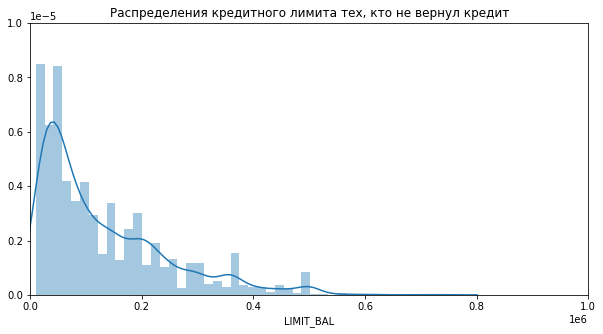

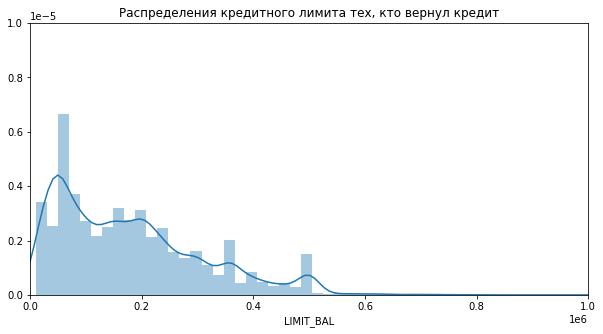

In [265]:
plt.figure(figsize=(10,5))
plt.title("Распределения кредитного лимита тех, кто не вернул кредит")
plt.xlim(0,1000000)
plt.ylim(0,0.00001)
sns.distplot(data.LIMIT_BAL[data.default==1])

plt.figure(figsize=(10,5))
plt.title("Распределения кредитного лимита тех, кто вернул кредит")
plt.xlim(0,1000000)
plt.ylim(0,0.00001)
sns.distplot(data.LIMIT_BAL[data.default==0])

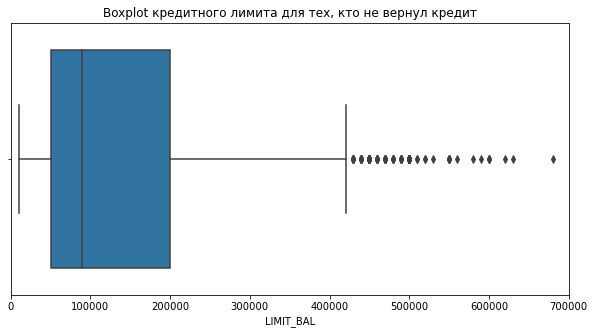

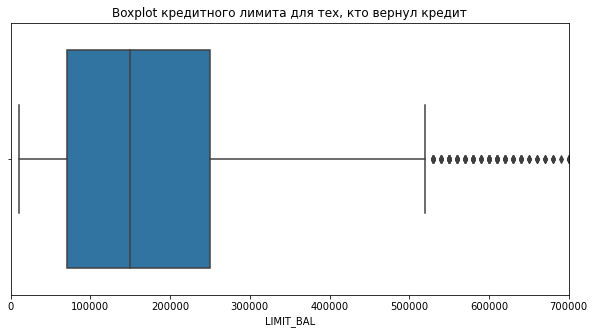

In [269]:
plt.figure(figsize=(10,5))
plt.title("Boxplot кредитного лимита для тех, кто не вернул кредит")
plt.xlim(0,700000)
sns.boxplot(data.LIMIT_BAL[data.default==1])

plt.figure(figsize=(10,5))
plt.title("Boxplot кредитного лимита для тех, кто вернул кредит")
plt.xlim(0,700000)
sns.boxplot(data.LIMIT_BAL[data.default==0])

###### Проверка равенства медианных значений кредитного лимита среди тех кто вернул кредит и тех, кто не вернул

H0: Медианные значения равны

H1: Медианные значения отличаются друг от друга

In [272]:
lim_bal_0 = data.LIMIT_BAL[data.default==0]
lim_bal_1 = data.LIMIT_BAL[data.default==1]

print("Медиана кредитного лимита для тех, кто вернул кредит",
     lim_bal_0.median())

print("Медиана кредитного лимита для тех, кто не вернул кредит",
     lim_bal_1.median())

Медиана кредитного лимита для тех, кто вернул кредит 150000.0
Медиана кредитного лимита для тех, кто не вернул кредит 90000.0


In [281]:
lim_bal_0_conf_int = zconfint(lim_bal_0)
lim_bal_1_conf_int = zconfint(lim_bal_1)

print("Доверительный интервал кредитного лимита для вернувших кредит:\n",
     lim_bal_0_conf_int)
print("")
print("Доверительный интервал кредитного лимита для не вернувших кредит:\n",
     lim_bal_1_conf_int)

Доверительный интервал кредитного лимита для вернувших кредит:
 (176411.91449742022, 179787.53765118445)

Доверительный интервал кредитного лимита для не вернувших кредит:
 (127333.65333983443, 132885.65949922524)


Как видно из интервальных оценок, медианы не совпадают. Таким образом, заемщики, которые не возвращают кредит берут меньшую сумму

###### Проверка гипотезы о равенстве распределений с помощью перестановочного критерия

H0: распределения выборок равны

H1: распределения отличаются на величину сдвига

In [383]:
p_value = permutation_test(lim_bal_0,lim_bal_1,max_permutations=1000)
print("p-value:",p_value)

p-value: 0.001


Нулевая гипотеза отвергается на уровне значимости 0.05. Разница в распределениях видна на графиках, доверительных интервалах и соответсвует здравому смыслу

###### Сравнение данных о возврате и невозврате относительно пола

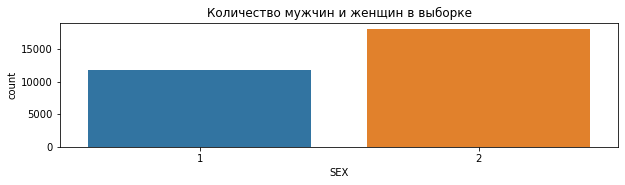

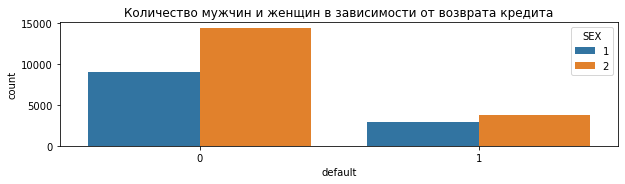

In [307]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title("Количество мужчин и женщин в выборке")
sns.countplot(data.SEX)

plt.figure(figsize=(10,5))
plt.subplot(2,1,2)
plt.title("Количество мужчин и женщин в зависимости от возврата кредита")
sns.countplot(data.default,hue=data.SEX)

 Построение доверительных интервалов для долей и их разности

In [322]:
sex_0 = data.SEX[data.default == 0]
sex_1 = data.SEX[data.default == 1]


m_to_w_0 = np.where(sex_0 == 1)[0].shape[0] / sex_0.shape[0]
m_to_w_1 = np.where(sex_1 == 1)[0].shape[0] / sex_1.shape[0]

print('Доля мужчин овернувших кредит' , m_to_w_0)
print('Доля мужчин не вернувших кредит' ,  m_to_w_1)

Доля мужчин овернувших кредит 0.38585002568053417
Доля мужчин не вернувших кредит 0.43294153104279687


In [323]:
conf_int_0 = proportion_confint(np.where(sex_0 == 1)[0].shape[0],
                                sex_0.shape[0])
conf_int_1 = proportion_confint(np.where(sex_1 == 1)[0].shape[0],
                                sex_1.shape[0])

print("Доверительный интервал для мужчин вернувших кредит\n",
     conf_int_0)
print("")
print("Доверительный интервал для мужчин не вернувших кредит\n",
     conf_int_1)

Доверительный интервал для мужчин вернувших кредит
 (0.37960806572767264, 0.3920919856333957)

Доверительный интервал для мужчин не вернувших кредит
 (0.4210202357094044, 0.44486282637618935)


Интервал для разности двух долей

In [324]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    
    return (left_boundary, right_boundary)

In [326]:
proportions_confint_diff_ind(np.abs(sex_0-2), np.abs(sex_1-2))

(-0.060548077974896725, -0.03363493274962867)

Доверительный интервал для разности долей не включает ноль, а значит можно говорить о различных долях возврата в зависимости от пола

######  Сравнение данных об образовании относительно возврата/невозврата

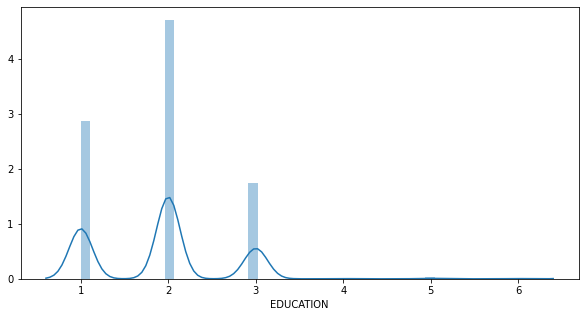

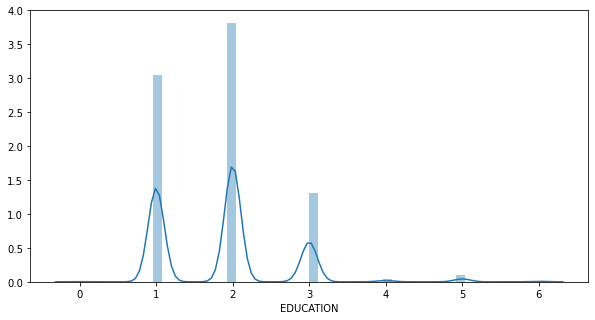

In [164]:
plt.figure(figsize=(10,5))
sns.distplot(ret.EDUCATION)
plt.figure(figsize=(10,5))
sns.distplot(noret.EDUCATION)

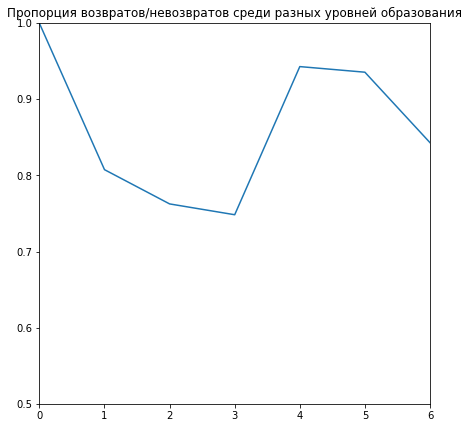

In [336]:
edu = data.EDUCATION
edu_0 = data.EDUCATION.loc[data.default == 0]
edu_1 = data.EDUCATION.loc[data.default == 1]

edu_prop = np.empty( (len(np.unique(edu_0)), 2) )
for i, ed_val in enumerate(np.unique(edu)):
    edu_prop[i, 0] = ed_val
    edu_prop[i, 1] = edu_0[edu_0 == ed_val].shape[0] / (edu_0[edu_0 == ed_val].shape[0] + edu_1[edu_1 == ed_val].shape[0])

    
_ = plt.figure(1, figsize=(7,7))
_ = plt.title('Пропорция возвратов/невозвратов среди разных уровней образования')
_ = plt.plot(edu_prop[:,0], edu_prop[:,1])
_ = plt.axis([0, 6, 0.5, 1])

По графикам видно, что образование влияет на возврат долга. 
Чаще всего возвращают люди с ученой степенью, а реже бакалавры и школьники

###### Проверка на соответствие распределения нормальному с помощью критерия согласия Пирсона ХИ-квадрат

H0: распределение признака нормально

H1: это не так

In [342]:
prop_0 = np.unique(data[data['default']==0].EDUCATION,return_counts=True)[1]
edu_prop_mean = edu_prop[:,1].mean()
exp_freq = np.array([prop_mean * edu_num[i] for i in range(7)])
p_val = stats.chisquare(prop_0,exp_freq,ddof=1)[1]

print("p-value:",p_val)

p-value: 3.653181595163598e-58


p - value с уверенностью позволяет отвергнуть нулевую гипотезу. Распределение признака отличается от нормального. Уровень образования влияет на вероятностью возрата/невозврата

###### Сравнение данных о семейном положении на  возврат/невозврат кредита

 Мерой зависимости между категориальными переменными может служить коэффициент V Крамера

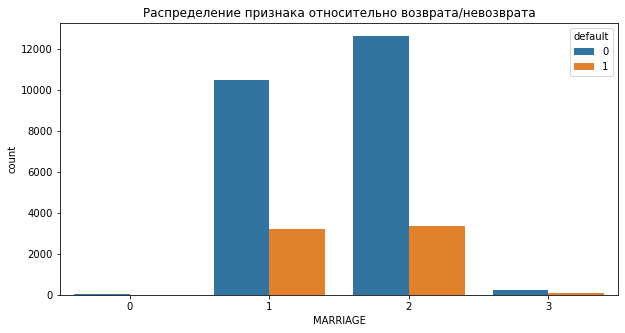

In [349]:
plt.figure(figsize=(10,5))
plt.title("Распределение признака относительно возврата/невозврата")
sns.countplot( data.MARRIAGE,hue=data.default )

In [343]:
ret_counts = np.unique( (data.MARRIAGE[data['default']==0]) ,
                       return_counts=True)[1] 

In [344]:
noret_counts = np.unique( (data.MARRIAGE[data['default']==1]) ,
                       return_counts=True)[1] 

In [345]:
from scipy import stats

def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))


In [352]:
obs = np.array([noret_counts,ret_counts])
cramers_stat(obs)

0.034478203662766466

Судя по коэффициенту Крамера линейной связи между полом и возвратом/невозвратом нет. Это соответствует здравому смыслу, а значит практическая значимость присутствует

# Сравнение данных о возрасте относительно возврата/невозврата

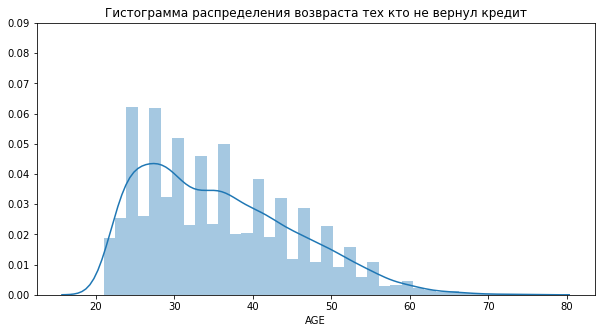

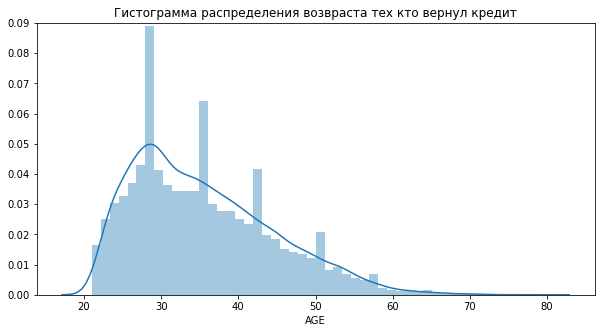

In [359]:
plt.figure(figsize=(10,5))
plt.title("Гистограмма распределения возвраста тех кто не вернул кредит")
plt.ylim(0,0.09)
sns.distplot(data.AGE[data["default"]==1])

plt.figure(figsize=(10,5))
plt.title("Гистограмма распределения возвраста тех кто вернул кредит")
plt.ylim(0,0.09)
sns.distplot(data.AGE[data["default"]==0])

In [361]:
ret_age = data.AGE[data["default"]==0]
noret_age = data.AGE[data["default"]==1]

print("Медиана возраста тех, кто вернул кредит:",ret_age.median())
print("Медиана возраста тех, кто не вернул кредит:",ret_age.median())

Медиана возраста тех, кто вернул кредит: 34.0
Медиана возраста тех, кто не вернул кредит: 34.0


###### Интервальная оценка медиан

In [381]:
ret_confint = zconfint(ret_age)
noret_confint = zconfint(noret_age)

print("95 Доверительный интервал для возраста вернувших кредит:\n",
     ret_confint)
print("")
print("95 Доверительный интервал для возраста не вернувших кредит:\n",
     noret_confint)

95 Доверительный интервал для возраста вернувших кредит:
 (35.300871020374075, 35.53366073788649)

95 Доверительный интервал для возраста не вернувших кредит:
 (35.49251465370673, 35.958962139542216)


Исходя из интервалов нельзя однозначно заявить о разности медиан

###### Проверка гипотезы о равенстве распределений при помощи непараметрического критерия проверки средних

H0: Распределения выборок равны
    
H1: Распределения выборок отличаются на величину сдвига

In [370]:
p_value = permutation_test(ret_age,noret_age,1000)
print("P-value:",p_value)

P-value: 0.015


Нулевая гипотеза отвергается на уровне значимости 0.05. Результат практически значим, соответствует здравому смыслу и визуализации

# Выводы

1) Заемщики, которые не возвращают кредит берут большую сумму

2) В данной выборке доли возврата среди полов значительно отличаются

3) Уроверь образования влияет на возврат долга

4) Возраст также влияет

# Задача №2
Сравнение результатов применения двух техник удержания абонентов сотовой связи

# Анализ эффективности удержания

state — штат США

account_length — длительность использования аккаунта

area_code — деление пользователей на псевдорегионы, использующееся в телекоме

intl_plan — подключена ли у пользователя услуга международного общения

vmail_plan — подключена ли у пользователя услуга голосовых сообщений

vmail_message — количество голосых сообщений, который пользователь отправил / принял

day_calls — сколько пользователь совершил дневных звонков

day_mins — сколько пользователь проговорил минут в течение дня

day_charge — сколько пользователь заплатил за свою дневную активность

eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности

night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности

intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения

custserv_calls — сколько раз пользователь позвонил в службу поддержки

treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная группа)

mes_estim — оценка интенсивности пользования интернет мессенджерами

churn — результат оттока: перестал ли абонент пользоваться услугами оператора

In [8]:
churn = pd.read_csv(r'/Users/roman/Desktop/churn analysis.csv')
churn.head(5)

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


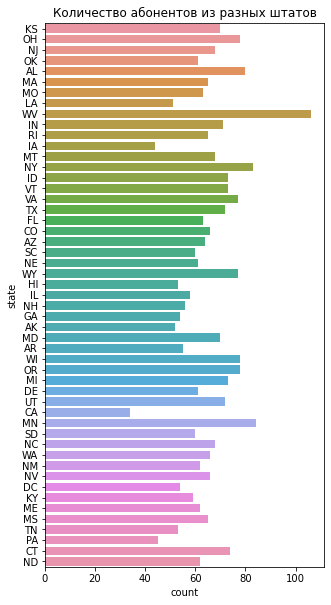

In [20]:
plt.figure(figsize=(5,10))
plt.title("Количество абонентов из разных штатов")
sns.countplot(y=churn.state)

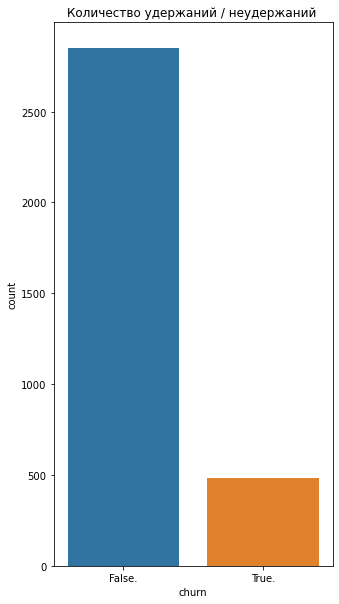

In [29]:
plt.figure(figsize=(5,10))
plt.title("Количество удержаний / неудержаний ")
sns.countplot(churn.churn)

###### Проверка гипотезы о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора

In [23]:
treatment = churn[churn['treatment']==1]

In [107]:
pivot_states = pd.pivot_table(treatment,
                             values='treatment',
                             index='state',
                             columns='churn',
                             aggfunc=len,
                             fill_value=0)

pivot_states.head()

churn,False.,True.
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [69]:
chi_2df = pd.DataFrame(columns= ["state#1","state#2","p-value"])
counter = 0

for first,second in itertools.combinations(pivot_states.index,2):
    conf_table = pivot_states.loc[[first,second],:]
    chi_2df.loc[counter,'state#1'] = first
    chi_2df.loc[counter,'state#2'] = second
    chi_2df.loc[counter,"p-value"] = chi2_contingency(conf_table.values,
                                                         correction=False)[1]
    counter = counter + 1
    
chi_2df.head()

,state#1,state#2,p-value
0,AK,AL,0.213621
1,AK,AR,0.0357288
2,AK,AZ,0.517397
3,AK,CA,0.0277369
4,AK,CO,0.101066


In [81]:
pd.DataFrame(np.unique(chi_2df["p-value"] < 0.05,return_counts=True))

,0,1
0,False,True
1,1241,34


###### Только для 34 из 1241 пар штатов можно отвергнуть нулевую гипотезу
###### Применим поправку Йетса (коррекция точности аппроксимации на непрерывность)

In [84]:
chi_2df_uets = pd.DataFrame(columns= ["state#1","state#2","p-value"])
counter = 0

for first,second in itertools.combinations(pivot_states.index,2):
    conf_table = pivot_states.loc[[first,second],:]
    chi_2df_uets.loc[counter,'state#1'] = first
    chi_2df_uets.loc[counter,'state#2'] = second
    chi_2df_uets.loc[counter,"p-value"] = chi2_contingency(conf_table.values,
                                                         correction=True)[1]
    counter = counter + 1
    
chi_2df_uets.head()

,state#1,state#2,p-value
0,AK,AL,0.423999
1,AK,AR,0.0989429
2,AK,AZ,0.963119
3,AK,CA,0.0804911
4,AK,CO,0.230821


In [85]:
pd.DataFrame(np.unique(chi_2df_uets["p-value"] < 0.05,return_counts=True))

,0
0,False
1,1275


###### Все достигаемые уровни значимости больше 0.05 и ни одно значение p-value не попадает в  [ 0 : 0.05 |

###### Корреляция между дневными звонками и интенсивностью использования мессенджера

In [103]:
print("Корреляция Пирсона:",stats.pearsonr(churn.day_calls,
                                           churn.mes_estim)[1])

print("p-value:",stats.pearsonr(churn.day_calls,
                                             churn.mes_estim)[0])

Корреляция Пирсона: 0.0027798836869738384
p-value: -0.051794350587572625


In [101]:
print("Корреляция Спирмена:",stats.spearmanr(churn.day_calls,
                                             churn.mes_estim)[1])

print("p-value:",stats.spearmanr(churn.day_calls,
                                             churn.mes_estim)[0])

Корреляция Спирмена: 0.012317367189170541
p-value: 0.043349880533927444


###### Анализ эффективности применных методов удержания

In [109]:
treatment_control = churn[churn['treatment']==1]
treatment_0 = churn[churn['treatment']==0]
treatment_2 = churn[churn['treatment']==2]

In [140]:
case_count0 = np.unique(treatment_0.churn,return_counts=True)[1]
case_count2 = np.unique(treatment_2.churn,return_counts=True)[1]
case_count_control = np.unique(treatment_control.churn,return_counts=True)[1]

print("Количество неудержаний/удержаний в контрольной группе ",case_count_control )
print("Количество неудержаний/удержаний при методе '0' ",case_count0 )
print("Количество неудержаний/удержаний при методе '2' ",case_count2 )

Количество неудержаний/удержаний в контрольной группе  [917 180]
Количество неудержаний/удержаний при методе '0'  [968 165]
Количество неудержаний/удержаний при методе '2'  [965 138]


######  Построение доверительных интервалов для результатов обоих методов удержания по методу Уилсона

In [138]:
control_confint = proportion_confint(case_count_control[1],
                   case_count_control[0],method='wilson')

case_0_confint = proportion_confint(case_count0[1],
                   case_count0[0],method='wilson')

case_2_confint = proportion_confint(case_count2[1],
                   case_count2[0],method='wilson')

print("Доверительный интервал для контрольной группы:\n",control_confint)
print("Доверительный интервал для метода '0':\n",case_0_confint)
print("Доверительный интервал для метода '2':\n",case_2_confint)

Доверительный интервал для контрольной группы:
 (0.1718738904211161, 0.22324456926103117)
Доверительный интервал для метода '0':
 (0.14807981567943956, 0.19543450529406836)
Доверительный интервал для метода '2':
 (0.12233145462055842, 0.16650987878122067)


In [163]:
control =  np.array(917*[1]+180*[0]) 
case0 = np.array(968*[1]+165*[0]) 
case2 = np.array(965*[1]+138*[0]) 

print("Доверительный интервал для разности долей котрольной группы и метода 0\n",
      proportions_confint_diff_ind(control,case0))

print("Доверительный интервал для разности долей котрольной группы и метода 2\n",
proportions_confint_diff_ind(control,case2))
      
print("Доверительный интервал для разности долей метода 2 и метода 0\n",
proportions_confint_diff_ind(case2,case0))

Доверительный интервал для разности долей котрольной группы и метода 0
 (-0.011583241590025106, 0.04848883584089464)
Доверительный интервал для разности долей котрольной группы и метода 2
 (0.00961876673809212, 0.06832230885668503)
Доверительный интервал для разности долей метода 2 и метода 0
 (-0.04885636806430281, 0.007820886720395197)


###### Проверка эффективности удержания

H0:  между двумя группами нет разницы
    
H1: разница есть

In [173]:
zc0 = proportions_diff_z_stat_ind(control,case0)
zc2 = proportions_diff_z_stat_ind(control,case2)
z02 = proportions_diff_z_stat_ind(case2,case0)

p_val_c0 = proportions_diff_z_test(zc0)
p_val_c2 = proportions_diff_z_test(zc2)
p_val_02 = proportions_diff_z_test(z02)

print("p-value для контрольной группы и метода 0:",p_val_c0)
print("p-value для контрольной группы и метода 2:",p_val_c2)
print("p-value для метода 0 и метода 2:",p_val_02)

p-value для контрольной группы и метода 0: 0.2283311639045107
p-value для контрольной группы и метода 2: 0.009348084294451109
p-value для метода 0 и метода 2: 0.1564246886050802


###### На основании данных на уровне значимости 0.05 нельзя однозначно сказать о том, что между методами есть статистически значимая разница

######  Применение поправки на множественную поправку гипотез

In [176]:
_,p_new,_,_ = multipletests([p_val_c0,p_val_c2,p_val_02],alpha=0.05,method='fdr_bh')

p_new

array([0.22833116, 0.02804425, 0.22833116])

# Вывод
###### С учетом поправки на множественную поправку можно утверждать, что метод 2 эффективнее всего